# Project Overview

This project is meant to highlight how and LSTM (Long Short Term Memory) recurrent neural network can be used in predicting stock prices. There are many different ways to implement predictive analytics into trading and this is just one way to do so. LSTM's are a technical tactic for predicting the stock market based of previous movements. More complex algorithms would also implement fundemental and text analysis, but the technical analysis is accessible for everyone.

The problem origin is simple. Predicting the stock market is a popular topic, and strategies for this is mostly comprised of machine learning and artificial intelligence. This prject uses basic stock prices using yfinance to gather the data.

## Problem Statement

Can an individual use an LSTM to predict the price of a stock 5 days into the future with using technical indicators of the stock and predict with a high enough accuracy to know when to buy or sell a stock?

## Metrics for Sucess

Metrics for success include low value losses and a low MSE. It is pertinent to keep in mind that since we are trying to predict 5 days into the future, the current price should be removed to get rid of the inherint bias in predicting off a lag function. 

## ETL for data (extraction)

The code below shows an example of how to download stock data using the yfinance python model. This includes a more pythonic example with the creation of classes. 

In [22]:
# imports needed to run all processes
import  yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [23]:
%%capture
# This process is used to download and get the name of all tickers needed 
# used the following we address to dowload the needed csv for manipulation
# https://www.nasdaq.com/market-activity/stocks/screener. I downloaded the Finance Tech and Energy Industries
nasdaq = pd.read_csv('nasdaq_screener.csv')
# change to list of tickers
tickers = [i for i in nasdaq['Symbol']]
# download first row of data
data = yf.download(tickers[0], start="2014-01-01", end="2021-01-01" ,group_by='Ticker')
# create row for ticker
data['ticker'] = tickers[0]
# for loop to append all other rows to initial one
for item in tickers[1:]:
    try:
        dat = yf.download(item, start="2014-01-01", end="2021-01-01" ,group_by='ticker')
    except ValueError:
        continue
    dat['ticker'] = item
    if dat.shape[0] == 0:
        continue
    data  = pd.concat([data, dat])
# write to csv
data.to_csv('nasdaq.csv') 

The code above could be implemented in a way to bne more pythonic. To see the pythonic version loo at the etl.py page. For the data preprocessing, two different ways are highlighted. The first way uses apache spark while the second uses sklearn. Spark is fastuer due to the Distributed file system so it is recomended. However, the LSTM is ran not available in the Hadoop machine learning system to the sklearn version is also highlighted. 

The code below preprocess the data by first initializing a spark instance, reading the CSV created in the extraction process, foreward fills the data that is missing, and adds 7 day, 20 day, and daily return and Bollinger Bands.

In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 19 14:46:53 2021

@author: akniels1
"""
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc, stddev_samp, stddev_pop, lag, lead
from pyspark.sql.functions import asc, col,avg, last
from pyspark.sql.functions import sum as Fsum
import pandas as pd
from pyspark.sql.window import Window
import sys


## Initialize a class for the fin_dataet
class fin_data:
    """
    Class for processing data in spark This is utilized to process financial data in spark
    
    """
    def __init__(self, list_of_csv = ["nasdaq.csv"] ):
        self._list_of_csv = list_of_csv
    
## initialize spark
    def initspark(self):
        """
        No Inputs
        
        Output - spark session called spark
        
        Creates a spark session called spark that can be utilized in the other processes. This function 
        must be initialized for other functions to work
        
        """
        spark = SparkSession \
            .builder \
            .appName("Python Fin Data") \
            .config("local") \
            .getOrCreate()
        return spark
## Read data from csv to spark dataframes         
    def read_csv_to_spark(self, spark):
        """
        No inputs
        
        Output - List or spark dataframes, name of spark tables. 
        
        creates a list of spark dataframes and names to be used in other functions 
        """
        list_of_spark =  []
        names_of_tables = []
        for item in self._list_of_csv:
            names_of_tables.append(str(item[:-4]))
            app =  spark.read.format("csv").option("header", "true").load(item)
            list_of_spark.append( app )
        return list_of_spark, names_of_tables
    
## union the data together
    
    def Spark_union(self,sprk_list, table_names, spark):
        """
        Input -  list of spark dataframes, list_of_names
        
        Output - unioned table
        
        unions tables together 
        
        """
        spark_string = ''
        for i in range(len(sprk_list)):
            sprk_list[i].createOrReplaceTempView(table_names[i])
            if i == (len(sprk_list)-1):
                spark_string += 'Select * from '+ table_names[i]
            else:
                spark_string +='Select * from '+ table_names[i]+ ' Union All '
        
        union_all = spark.sql(spark_string)
        return union_all
 ## fron fill the data and remove any NAN values   
    def ffill_and_remove(self, sparktable):
        # define the window
        window = Window.partitionBy('ticker')\
                       .orderBy('Date')\
                       .rowsBetween(-sys.maxsize, 0)

        # define the forward-filled column
        clean_open = last(sparktable['Open'], ignorenulls=True).over(window)
        clean_high = last(sparktable['High'], ignorenulls=True).over(window)
        clean_low = last(sparktable['Low'], ignorenulls=True).over(window)
        clean_close = last(sparktable['Close'], ignorenulls=True).over(window)
        clean_adj_close = last(sparktable['Adj Close'], ignorenulls=True).over(window)
        clean_volume = last(sparktable['Volume'], ignorenulls=True).over(window)

        # do the fill
        spark_df_filled = sparktable.withColumn('Open', clean_open)
        spark_df_filled = spark_df_filled.withColumn('High', clean_high)
        spark_df_filled = spark_df_filled.withColumn('Low', clean_low)
        spark_df_filled = spark_df_filled.withColumn('Close', clean_close)
        spark_df_filled = spark_df_filled.withColumn('Adj Close', clean_adj_close)
        spark_df_filled = spark_df_filled.withColumn('Volume', clean_volume)

        #remove items that are blank (beforestock inception)
        spark_df_filled.na.drop('any')

        
        return spark_df_filled




        
    
    def add_additional_fields(self,table):
        days = lambda i: i * 86400

        
        windowSpec = Window.partitionBy("ticker").orderBy(col("Date").cast('long')).rowsBetween(-7, 0)
        
        windowSpec20 = Window.partitionBy("ticker").orderBy(col("Date").cast('long')).rowsBetween(-20, 0)
        
        date_spec = Window.partitionBy("ticker").orderBy("Date")
        
        
        
        
        
        union_table = table.withColumn('rolling_seven_day_average', avg("Close").over(windowSpec)) 
        
        union_table = union_table.withColumn('rolling_20_day_average', avg("Close").over(windowSpec20)) 
        
        union_table = union_table.withColumn('Prev Close', lag("Close").over(date_spec))
        
        union_table = union_table.withColumn('Lead 5 Close', lag(col("Close"), 5).over(date_spec))


        
        union_table = union_table.withColumn('DailyReturn',  (union_table['Close'] - union_table['Prev Close'])/ 
union_table['Close'] )


        
        union_table = union_table.withColumn('stdev', stddev_pop("Close").over(windowSpec20))
        
        union_table = union_table.withColumn('Upper', union_table['rolling_20_day_average'] + (union_table['stdev']*2) )
        
        union_table = union_table.withColumn('Lower', union_table['rolling_20_day_average'] - (union_table['stdev']*2) )
        
        return union_table
    
    def get_distinct_tickers(self, sparkframe):
         
        
        return [i.ticker for i in sparkframe.select('ticker').distinct().collect()]
        

fin = fin_data()    
spark = fin.initspark()   
list_spark , table_name = fin.read_csv_to_spark(spark)
union_all = fin.Spark_union(list_spark, table_name,spark)
clean_data = fin.ffill_and_remove(union_all)
final_dataset = fin.add_additional_fields(clean_data)
distinct_tickers = fin.get_distinct_tickers(final_dataset)

In [25]:
display(final_dataset)

DataFrame[Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string, ticker: string, rolling_seven_day_average: double, rolling_20_day_average: double, Prev Close: string, Lead 5 Close: string, DailyReturn: double, stdev: double, Upper: double, Lower: double]

## Data Exploration and Visualization

The code below creates a sql view of the dataset to make it easier for filtering. To visualize the data, the rows are limited to 1 stock and for a specific time period. The visulations following look at the trends for a short period time, and then add the bollinger 20 day bands. AIG data is extracted and the daily returns of both are compared. 

In [26]:
## create sql view
final_dataset.createOrReplaceTempView('stocks')


In [27]:
## limit to PFG data
PFG = spark.sql("Select * from stocks where ticker = 'PFG' and date >= '2020-12-01'")
PFG = PFG.toPandas()
PFG

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,rolling_seven_day_average,rolling_20_day_average,Prev Close,Lead 5 Close,DailyReturn,stdev,Upper,Lower
0,2020-12-01,50.029998779296875,50.150001525878906,49.06999969482422,49.619998931884766,49.619998931884766,2550900.0,PFG,50.497500,47.105238,49.790000915527344,50.63999938964844,-0.003426,3.686012,54.477262,39.733214
1,2020-12-02,49.290000915527344,51.09000015258789,49.08000183105469,50.86000061035156,50.86000061035156,1398000.0,PFG,50.738750,47.636191,49.619998931884766,52.599998474121094,0.024381,3.372218,54.380626,40.891755
2,2020-12-03,50.540000915527344,51.84000015258789,50.540000915527344,51.36000061035156,51.36000061035156,1374900.0,PFG,51.033750,48.091429,50.86000061035156,52.0,0.009735,3.194210,54.479848,41.703009
3,2020-12-04,51.91999816894531,52.70000076293945,51.849998474121094,52.279998779296875,52.279998779296875,1111400.0,PFG,51.238750,48.594286,51.36000061035156,51.400001525878906,0.017598,2.975306,54.544897,42.643674
4,2020-12-07,51.650001525878906,51.70000076293945,50.34000015258789,50.709999084472656,50.709999084472656,1377600.0,PFG,51.002500,48.960952,52.279998779296875,49.790000915527344,-0.030960,2.728771,54.418494,43.503411
5,2020-12-08,50.040000915527344,51.06999969482422,50.040000915527344,50.77000045776367,50.77000045776367,1444800.0,PFG,50.848750,49.408572,50.709999084472656,49.619998931884766,0.001182,2.158179,53.724929,45.092214
6,2020-12-09,51.189998626708984,51.369998931884766,50.0099983215332,50.04999923706055,50.04999923706055,1764600.0,PFG,50.680000,49.523333,50.77000045776367,50.86000061035156,-0.014386,2.124903,53.773139,45.273528
7,2020-12-10,49.119998931884766,50.06999969482422,49.0,49.81999969482422,49.81999969482422,1848500.0,PFG,50.683750,49.646190,50.04999923706055,51.36000061035156,-0.004617,2.063018,53.772226,45.520155
8,2020-12-11,48.7599983215332,49.529998779296875,48.369998931884766,48.77000045776367,48.77000045776367,1485100.0,PFG,50.577500,49.799524,49.81999969482422,52.279998779296875,-0.021530,1.862820,53.525164,46.073883
9,2020-12-14,49.689998626708984,49.97999954223633,47.599998474121094,47.81999969482422,47.81999969482422,2074700.0,PFG,50.197500,49.953333,48.77000045776367,50.709999084472656,-0.019866,1.529934,53.013201,46.893465


In [28]:
%matplotlib inline
## plot stock price and rolling average
fig = go.Figure()
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.Close,
                    mode='lines',
                    name='Close'))
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.rolling_20_day_average,
                    mode='lines',
                    name='20 Day Rollling Average'))


In [29]:
%matplotlib inline
## plot bollinger™ bands
fig = go.Figure()
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.Close,
                    mode='lines',
                    name='Close'))
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.Upper,
                    mode='lines',
                    name='Upper Bollinger™'))
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.Lower,
                    mode='lines',
                    name='Lower Bollinger™'))

In [30]:
%matplotlib inline
## Plot PFG Daily Returns
fig = go.Figure()
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.DailyReturn,
                    mode='lines',
                    name='DailyReturn'))

In [31]:
## get AIG stock
AIG = spark.sql("Select * from stocks where ticker = 'AIG' and date >= '2020-12-01'")
AIG = AIG.toPandas()
AIG

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,rolling_seven_day_average,rolling_20_day_average,Prev Close,Lead 5 Close,DailyReturn,stdev,Upper,Lower
0,2020-12-01,39.5,39.779998779296875,39.09000015258789,39.310001373291016,38.99322509765625,6245700.0,AIG,39.435000,37.187619,38.439998626708984,39.77000045776367,0.022132,2.726501,42.640621,31.734617
1,2020-12-02,39.060001373291016,39.88999938964844,38.7599983215332,39.72999954223633,39.40983963012695,5175400.0,AIG,39.583750,37.534286,39.310001373291016,40.97999954223633,0.010571,2.559808,42.653901,32.414671
2,2020-12-03,39.66999816894531,40.27000045776367,39.52000045776367,39.84000015258789,39.518951416015625,4581300.0,AIG,39.737500,37.865238,39.72999954223633,40.119998931884766,0.002761,2.380993,42.627225,33.103251
3,2020-12-04,40.25,40.810001373291016,40.150001525878906,40.689998626708984,40.36210250854492,4597600.0,AIG,39.852499,38.298571,39.84000015258789,39.709999084472656,0.020890,1.996533,42.291638,34.305505
4,2020-12-07,40.279998779296875,40.34000015258789,39.56999969482422,39.790000915527344,39.469356536865234,4478500.0,AIG,39.703750,38.601428,40.689998626708984,38.439998626708984,-0.022619,1.694589,41.990606,35.212251
5,2020-12-08,39.279998779296875,39.95000076293945,39.18000030517578,39.52000045776367,39.20153045654297,3322600.0,AIG,39.628750,38.904286,39.790000915527344,39.310001373291016,-0.006832,1.187488,41.279263,36.529309
6,2020-12-09,39.90999984741211,40.290000915527344,39.560001373291016,39.939998626708984,39.61814498901367,5388400.0,AIG,39.657500,39.019524,39.52000045776367,39.72999954223633,0.010516,1.164766,41.349056,36.689991
7,2020-12-10,39.279998779296875,39.939998626708984,39.060001373291016,39.709999084472656,39.38999938964844,4716300.0,AIG,39.816250,39.090000,39.939998626708984,39.84000015258789,-0.005792,1.159626,41.409252,36.770747
8,2020-12-11,38.83000183105469,39.16999816894531,38.560001373291016,38.790000915527344,38.790000915527344,5299000.0,AIG,39.751250,39.158571,39.709999084472656,40.689998626708984,-0.023717,1.095511,41.349594,36.967549
9,2020-12-14,39.29999923706055,39.369998931884766,38.08000183105469,38.15999984741211,38.15999984741211,3942000.0,AIG,39.555000,39.258571,38.790000915527344,39.790000915527344,-0.016509,0.883420,41.025411,37.491731


In [32]:
## Plot daily returns of PFG and AIG
fig = go.Figure()
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.DailyReturn,
                    mode='lines',
                    name='DailyReturn PFG'))
fig.add_trace(go.Scatter(x=AIG.Date, y=AIG.DailyReturn,
                    mode='lines',
                    name='DailyReturn AIG'))




## Machine Learning Section

#### Maching learning exploration

The goal of the first four sections is to load necessary modules and structure the data for correlation analysis. The purpose of the code is to look at correlations in the data with the categories from the nasdaq screener included. The lines join the data together, check the row count and also run the correlation

In [33]:
# LSTM for Stock Market prediction
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [34]:
## read in the finance data to get mored descriptive attributes

spark = SparkSession \
            .builder \
            .appName("Python Fin Data") \
            .config("local") \
            .getOrCreate()
app =  spark.read.format("csv").option("header", "true").load('nasdaq_screener.csv')


app.createOrReplaceTempView('nasdaq')

row_count = spark.sql("Select count(*) from stocks ")

row_count.toPandas().head()





,count(1)
0,451227


In [35]:
app

DataFrame[Symbol: string, Name: string, Last Sale: string, Net Change: string, % Change: string, Market Cap: string, Country: string, IPO Year: string, Volume: string, Sector: string, Industry: string]

In [36]:

## join to screener data and check row count 
row_count_join = spark.sql("""
                            Select count(*) from

                            (Select *
                           from stocks s 
                           left join nasdaq n 
                           on s.Ticker = n.Symbol)
                           
                           """)
row_count.toPandas().head()

,count(1)
0,451227


In [37]:
## get data for correlation
data_lake = spark.sql("""
                           

                            (Select stocks.* ,nasdaq.Sector, nasdaq.Industry
                           from stocks
                           left join nasdaq 
                           on Ticker = Symbol)
                           
                           """)
data_lake.limit(10).toPandas().head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,rolling_seven_day_average,rolling_20_day_average,Prev Close,Lead 5 Close,DailyReturn,stdev,Upper,Lower,Sector,Industry
0,2020-07-02,50.060001373291016,70.80000305175781,49.02000045776367,69.41000366210938,69.41000366210938,18371900.0,LMND,69.410004,69.410004,None,None,NaN,0.000000,69.410004,69.410004,Finance,Property-Casualty Insurers
1,2020-07-06,73.39399719238281,96.51000213623047,73.11000061035156,81.19000244140625,81.19000244140625,13467900.0,LMND,75.300003,75.300003,69.41000366210938,None,0.145092,5.889999,87.080002,63.520004,Finance,Property-Casualty Insurers
2,2020-07-07,83.80000305175781,89.37999725341797,75.0,78.79000091552734,78.79000091552734,4602800.0,LMND,76.463336,76.463336,81.19000244140625,None,-0.030461,5.082789,86.628914,66.297757,Finance,Property-Casualty Insurers
3,2020-07-08,79.0,79.38999938964844,68.05999755859375,68.51000213623047,68.51000213623047,3499200.0,LMND,74.475002,74.475002,78.79000091552734,None,-0.150051,5.588960,85.652922,63.297083,Finance,Property-Casualty Insurers
4,2020-07-09,73.97000122070312,79.91000366210938,69.02999877929688,77.01000213623047,77.01000213623047,4178700.0,LMND,74.982002,74.982002,68.51000213623047,None,0.110375,5.100723,85.183448,64.780557,Finance,Property-Casualty Insurers


More data transformation is completed below in order to prep the data for machine learning in spark the data below indexes the categorical data into a string.

In [39]:
## transform data into encoded data

from pyspark.ml.feature import StringIndexer

stringindex = StringIndexer(inputCols=["ticker","Sector", "Industry"], outputCols=["ticker_vector","Sector_vector", "Industry_Vector"])
model = stringindex.fit(data_lake)
encoded = model.transform(data_lake)
clean_data_lake = encoded.drop('Industry', 'Sector', 'ticker')
clean_data_lake = clean_data_lake.filter(clean_data_lake.DailyReturn. isNotNull())
clean_data_lake = clean_data_lake.select(*(col(c).cast("float").alias(c) for c in clean_data_lake.columns))
df = clean_data_lake.toPandas()
df.dtypes

Date                         float32
Open                         float32
High                         float32
Low                          float32
Close                        float32
Adj Close                    float32
Volume                       float32
rolling_seven_day_average    float32
rolling_20_day_average       float32
Prev Close                   float32
Lead 5 Close                 float32
DailyReturn                  float32
stdev                        float32
Upper                        float32
Lower                        float32
ticker_vector                float32
Sector_vector                float32
Industry_Vector              float32
dtype: object

This show the Actual corrrelation of the data. all the technigal indicatiors are really highly coorelated with one another while the categorical and sector data is not correlated. Industry and sector data can be removed due to the predictive power

In [40]:
# from pyspark.ml.stat import Correlation
# from pyspark.conf import SparkConf
## correlation of data
df.corr()

,Date,Open,High,Low,Close,Adj Close,Volume,rolling_seven_day_average,rolling_20_day_average,Prev Close,Lead 5 Close,DailyReturn,stdev,Upper,Lower,ticker_vector,Sector_vector,Industry_Vector
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,NaN,1.000000,0.999917,0.999912,0.999859,0.998930,-0.084121,0.999688,0.998861,0.999942,0.999191,0.002815,0.661140,0.997306,0.998140,0.022138,NaN,-0.028296
High,NaN,0.999917,1.000000,0.999854,0.999919,0.999045,-0.084064,0.999661,0.998907,0.999867,0.999167,0.005951,0.664984,0.997588,0.997928,0.022436,NaN,-0.028205
Low,NaN,0.999912,0.999854,1.000000,0.999920,0.998947,-0.084194,0.999577,0.998674,0.999850,0.999038,0.006664,0.657156,0.996879,0.998214,0.021928,NaN,-0.028384
Close,NaN,0.999859,0.999919,0.999920,1.000000,0.999074,-0.084168,0.999592,0.998760,0.999797,0.999066,0.009841,0.661181,0.997211,0.998031,0.022179,NaN,-0.028286
Adj Close,NaN,0.998930,0.999045,0.998947,0.999074,1.000000,-0.082691,0.998663,0.997828,0.998870,0.998140,0.009622,0.664331,0.996514,0.996845,0.028401,NaN,-0.026224
Volume,NaN,-0.084121,-0.084064,-0.084194,-0.084168,-0.082691,1.000000,-0.083892,-0.083471,-0.084086,-0.083796,-0.012387,-0.052714,-0.083184,-0.083583,-0.071385,NaN,-0.096601
rolling_seven_day_average,NaN,0.999688,0.999661,0.999577,0.999592,0.998663,-0.083892,1.000000,0.999486,0.999727,0.999821,0.000835,0.663480,0.998049,0.998634,0.022013,NaN,-0.028450
rolling_20_day_average,NaN,0.998861,0.998907,0.998674,0.998760,0.997828,-0.083471,0.999486,1.000000,0.998931,0.999442,-0.000419,0.669884,0.998938,0.998737,0.021721,NaN,-0.028750
Prev Close,NaN,0.999942,0.999867,0.999850,0.999797,0.998870,-0.084086,0.999727,0.998931,1.000000,0.999237,-0.000714,0.661632,0.997403,0.998179,0.022131,NaN,-0.028331


The code below attempts to run a predictive anaysis with a pyspark pipeline. The data is constructed in a way that a pipeline is made to transfprm the data and then use the GBT regressor to try and predict the data. 

In [41]:


## Spark exploration (not used )
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline

pfg_data = spark.sql("""
                            (Select stocks.* ,nasdaq.Sector, nasdaq.Industry
                           from stocks
                           left join nasdaq 
                           on Ticker = Symbol
                           where stocks.Ticker = 'PFG')
                           """)
pfg_data.dtypes
stringindex = StringIndexer(inputCols=["ticker","Sector", "Industry"], outputCols=["ticker_vector","Sector_vector", "Industry_Vector"])
model = stringindex.fit(pfg_data)
encoded = model.transform(pfg_data)
clean_data_lake = clean_data_lake.filter(clean_data_lake.DailyReturn. isNotNull())
clean_data_lake = clean_data_lake.select(*(col(c).cast("float").alias(c) for c in clean_data_lake.columns))
#scaler_ticker = MinMaxScaler(inputCol=["ticker_vector","Sector_vector", "Industry_Vector","Open", "High", "Low", "Volume","rolling_20_day_average","Upper", "Lower"], outputCol=["ticker_vector","Sector_vector", "Industry_Vector","Open", "High", "Low", "Volume","rolling_20_day_average", "Upper", "Lower"])
columns_to_scale = ["Open", "High", "Low", "Volume","rolling_20_day_average","Upper", "Lower"]
assemblers = [VectorAssembler(inputCols=[columns_to_scale], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(clean_data_lake)
scaledData = scalerModel.transform(clean_data_lake)

TypeError: Invalid param value given for param "inputCols". Could not convert [['Open', 'High', 'Low', 'Volume', 'rolling_20_day_average', 'Upper', 'Lower']] to list of strings

In [38]:
## test for time series split in SPark
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)
pfscaled = scaledData.toPandas()

In [39]:
## get the data needed for pandas
pfg_data_final = spark.sql("""
                            (Select stocks.* ,nasdaq.Sector, nasdaq.Industry
                           from stocks
                           left join nasdaq 
                           on Ticker = Symbol
                           where stocks.Ticker = 'PFG')
                           """)
pfg_pandas = pfg_data_final.toPandas()
pfg_pandas = pfg_pandas.drop(['Sector', 'Industry', 'ticker'], axis = 1)
pfg_pandas   = pfg_pandas.dropna()
pfg_pandas = pfg_pandas.set_index('Date')
pfg_lead = pfg_pandas.pop('Lead 5 Close') # remove column b and store it in df1
pfg_pandas['Lead 5 Close']=pfg_lead # add b series as a 'new' column.

pfg_pandas.head(10)

,Open,High,Low,Close,Adj Close,Volume,rolling_seven_day_average,rolling_20_day_average,Prev Close,DailyReturn,stdev,Upper,Lower,Lead 5 Close
Date,,,,,,,,,,,,,,
2014-01-09,49.470001220703125,49.83000183105469,49.189998626708984,49.790000915527344,38.884979248046875,1178300.0,49.091667,49.091667,49.130001068115234,0.013256,0.350782,49.793230,48.390103,48.619998931884766
2014-01-10,49.84000015258789,49.84000015258789,49.16999816894531,49.560001373291016,38.705360412597656,815300.0,49.158572,49.158572,49.790000915527344,-0.004641,0.363768,49.886107,48.431036,48.959999084472656
2014-01-13,49.0,49.29999923706055,47.63999938964844,47.720001220703125,37.268348693847656,1611100.0,48.978750,48.978750,49.560001373291016,-0.038558,0.584924,50.148598,47.808902,49.0099983215332
2014-01-14,47.83000183105469,48.349998474121094,47.63999938964844,48.349998474121094,37.76036834716797,1227700.0,48.945000,48.908889,47.720001220703125,0.013030,0.585804,50.080496,47.737282,49.040000915527344
2014-01-15,48.36000061035156,48.38999938964844,48.08000183105469,48.220001220703125,37.658851623535156,1988400.0,48.852500,48.840000,48.349998474121094,-0.002696,0.592925,50.025850,47.654150,49.130001068115234
2014-01-16,48.130001068115234,48.279998779296875,47.7599983215332,47.939998626708984,37.440162658691406,1145000.0,48.718750,48.758182,48.220001220703125,-0.005841,0.621725,50.001633,47.514731,49.790000915527344
2014-01-17,47.810001373291016,48.04999923706055,47.40999984741211,47.439998626708984,37.04967498779297,1380000.0,48.518750,48.648333,47.939998626708984,-0.010540,0.697900,50.044133,47.252533,49.560001373291016
2014-01-21,47.7400016784668,47.959999084472656,47.189998626708984,47.33000183105469,36.96377182006836,1465400.0,48.293750,48.546923,47.439998626708984,-0.002324,0.756972,50.060866,47.032980,47.720001220703125
2014-01-22,47.54999923706055,47.650001525878906,47.0099983215332,47.22999954223633,36.885677337646484,1315900.0,47.973750,48.452857,47.33000183105469,-0.002117,0.804429,50.061716,46.843999,48.349998474121094


In [45]:
## scaling the data

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from math import sqrt

# normalize the dataset
values = pfg_pandas.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_pfg = scaler.fit_transform(values)
#dataset = scaler.fit_transform(pfg_pandas)

In [46]:
## break data into train and test
n_train_hours = int(len(pfg_pandas) * .8)
train = scaled_pfg[:n_train_hours, :]
test = scaled_pfg[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1406, 1, 13) (1406,) (352, 1, 13) (352,)


Epoch 1/60
10/10 - 1s - loss: 0.4495 - val_loss: 0.2479
Epoch 2/60
10/10 - 0s - loss: 0.2428 - val_loss: 0.0850
Epoch 3/60
10/10 - 0s - loss: 0.0529 - val_loss: 0.1000
Epoch 4/60
10/10 - 0s - loss: 0.0690 - val_loss: 0.0479
Epoch 5/60
10/10 - 0s - loss: 0.0477 - val_loss: 0.0430
Epoch 6/60
10/10 - 0s - loss: 0.0293 - val_loss: 0.0615
Epoch 7/60
10/10 - 0s - loss: 0.0327 - val_loss: 0.0391
Epoch 8/60
10/10 - 0s - loss: 0.0261 - val_loss: 0.0398
Epoch 9/60
10/10 - 0s - loss: 0.0230 - val_loss: 0.0362
Epoch 10/60
10/10 - 0s - loss: 0.0217 - val_loss: 0.0347
Epoch 11/60
10/10 - 0s - loss: 0.0198 - val_loss: 0.0326
Epoch 12/60
10/10 - 0s - loss: 0.0190 - val_loss: 0.0321
Epoch 13/60
10/10 - 0s - loss: 0.0184 - val_loss: 0.0307
Epoch 14/60
10/10 - 0s - loss: 0.0182 - val_loss: 0.0303
Epoch 15/60
10/10 - 0s - loss: 0.0182 - val_loss: 0.0301
Epoch 16/60
10/10 - 0s - loss: 0.0182 - val_loss: 0.0299
Epoch 17/60
10/10 - 0s - loss: 0.0182 - val_loss: 0.0299
Epoch 18/60
10/10 - 0s - loss: 0.0181 - 

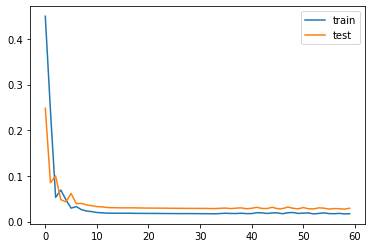

In [47]:
## lstm model
from matplotlib import pyplot
model = Sequential()
model.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=150, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history

#plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [48]:
## results of LSTM
yhat = model.predict(test_X)
rmse = sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.039
